# Bit string reversal task - assembled as a single jupyter notebook for easier use w/ colab

# Constants

In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 64
SEQ_LENGTH = 60       
HIDDEN_DIM = 64
STACK_DEPTH = SEQ_LENGTH
LEARNING_RATE = 1e-3
STEPS = 2000

# input
VOCAB_PAD, VOCAB_0, VOCAB_1, VOCAB_EQ = 0, 1, 2, 3
VOCAB_SIZE = 4

# stack
STACK_NULL, STACK_0, STACK_1 = 0, 1, 2
STACK_VOCAB_SIZE = 3

# memory actions
ACT_NOOP, ACT_PUSH_0, ACT_PUSH_1, ACT_POP = 0, 1, 2, 3
NUM_MEM_ACTIONS = 4

# buffer
OUT_NOOP, OUT_EMIT_0, OUT_EMIT_1 = 0, 1, 2
NUM_BUF_ACTIONS = 3

#controller states
STATE_READ = 0
STATE_WRITE = 1
NUM_STATES = 2

### Check whether using GPU

In [2]:
print("JAX Backend:", jax.default_backend())
print("Devices:", jax.devices())

JAX Backend: cpu
Devices: [CpuDevice(id=0)]


--- 
# Data generation

In [3]:
def generate_rev_trace(batch_size, seq_length=SEQ_LENGTH):
    """
    Generate data for the reverse task with full traces
    """

    lengths = np.random.randint(1, seq_length + 1, size=batch_size)
    seq_len = 2 * seq_length + 1  # input + = + output 

    inputs = np.full((batch_size, seq_len), VOCAB_PAD, dtype=np.int32)
    target_act = np.full((batch_size, seq_len), ACT_NOOP, dtype=np.int32)
    target_buf = np.full((batch_size, seq_len), OUT_NOOP, dtype=np.int32)
    target_state = np.full((batch_size, seq_len), STATE_READ, dtype=np.int32)
    
    
    for i in range(batch_size):
        L = lengths[i]
        bits = np.random.randint(1, 3, size=L)
        
        # read 
        # Input: bits + '='
        inputs[i, :L] = bits
        inputs[i, L] = VOCAB_EQ
        
        pop_start = L # start at equal!
        pop_end = pop_start + L
        
        target_act[i, :L] = bits
        
        # State
        target_state[i, :L] = STATE_READ
        target_state[i, L] = STATE_WRITE 
        
        # write
        target_act[i,pop_start : pop_end] = ACT_POP
        
        # buffer: Emit the popped bits 
        # DELAYED BY 1!!
        reversed_bits = bits[::-1]
        target_buf[i, pop_start+1 : pop_end+1] = reversed_bits 
        
        # State: stays in WRITE
        target_state[i, pop_start : pop_end] = STATE_WRITE

            
    return jnp.array(inputs), jnp.array(target_act), jnp.array(target_buf), jnp.array(target_state)


# test
inputs, tgt_a, tgt_b, tgt_s = generate_rev_trace(2)
print("Inputs:\n", inputs)
print("Target Mem Actions:\n", tgt_a)
print("Target Buffer Actions:\n", tgt_b)
print("Target States:\n", tgt_s)


Inputs:
 [[2 1 1 1 1 2 1 2 2 2 2 2 2 2 2 1 1 2 1 2 1 2 1 2 2 2 2 2 3 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0]]
Target Mem Actions:
 [[2 1 1 1 1 2 1 2 2 2 2 2 2 2 2 1 1 2 1 2 1 2 1 2 2 2 2 2 3 3 3 3 3 3 3 3
  3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

---
# Stack Utils

In [5]:
def update_stack(stack, ptr, action):
    """
    stack update
    
    stack: [Depth]
    ptr: Scalar index
    action: Scalar action
    """
    # Actions:
    # NOOP: No change.
    # PUSH 0: stack[ptr] = STACK_0, ptr++
    # PUSH 1: stack[ptr] = STACK_1, ptr++
    # POP: val = stack[ptr-1], ptr--
    
    # READ
    pop_ptr = jnp.maximum(0, ptr - 1)
    popped_val = stack[pop_ptr]
    
    # WRITE
    push_val = action 
    
    # UPDATE
    is_push = (action == ACT_PUSH_0) | (action == ACT_PUSH_1)
    new_stack_push = stack.at[ptr].set(push_val)
    new_ptr_push = ptr + 1
    
    is_pop = (action == ACT_POP)
    new_ptr_pop = pop_ptr

    new_stack_pop = stack.at[pop_ptr].set(STACK_NULL) 
    
    # Combine
    stack = jnp.where(is_push, new_stack_push, stack)
    stack = jnp.where(is_pop, new_stack_pop, stack)
    
    ptr = jnp.where(is_push, new_ptr_push, ptr)
    ptr = jnp.where(is_pop, new_ptr_pop, ptr)
    
    r_t = jnp.where(is_pop, popped_val, STACK_NULL)
    
    return stack, ptr, r_t

#test 
stack = jnp.array([0,0,0,0,0])
ptr = 0
actions = [ACT_PUSH_0, ACT_PUSH_1, ACT_POP, ACT_POP]
for a in actions:
    stack, ptr, r = update_stack(stack, ptr, a)
    print(f"Action: {a}, Stack: {stack}, Ptr: {ptr}, R_t: {r}")
    

Action: 1, Stack: [1 0 0 0 0], Ptr: 1, R_t: 0
Action: 2, Stack: [1 2 0 0 0], Ptr: 2, R_t: 0
Action: 3, Stack: [1 0 0 0 0], Ptr: 1, R_t: 2
Action: 3, Stack: [0 0 0 0 0], Ptr: 0, R_t: 1


--- 
# Models

In [6]:
class StackMachineCell(nn.Module):
    """
    Single step of the machine.
    Wrapped in nn.scan to handle recurrence.
    """
    stack_depth: int = STACK_DEPTH
    
    @nn.compact
    def __call__(self, carry, inputs):
        
        #unpack carry and inp
        stack, ptr, r_prev, s_prev = carry
        x_t, true_act, true_s, use_forcing = inputs
        
        #controller
        x_emb = nn.Embed(VOCAB_SIZE, HIDDEN_DIM)(x_t)
        s_emb = jax.nn.one_hot(s_prev, NUM_STATES)
        r_emb = jax.nn.one_hot(r_prev, STACK_VOCAB_SIZE)
        
        flat_input = jnp.concatenate([x_emb, s_emb, r_emb], axis=-1)
        
        logits_mem = nn.Dense(NUM_MEM_ACTIONS, name="head_mem")(flat_input)
        logits_buf = nn.Dense(NUM_BUF_ACTIONS, name="head_buf")(flat_input)
        logits_state = nn.Dense(NUM_STATES, name="head_state")(flat_input)
        
        # decide actions
        pred_act = jnp.argmax(logits_mem, axis=-1)
        pred_state = jnp.argmax(logits_state, axis=-1)
        
        # If use_forcing is True, use true_act,else use pred_act
        action_to_exec = jnp.where(use_forcing > 0, true_act, pred_act)
        next_s = jnp.where(use_forcing > 0, true_s, pred_state)
        
        # Update Stack
        stack_new, ptr_new, r_new = jax.vmap(update_stack)(stack, ptr, action_to_exec)
        
        new_carry = (stack_new, ptr_new, r_new, next_s)
        outputs = (logits_mem, logits_buf, logits_state)
        
        return new_carry, outputs

class NeuralStackMachine(nn.Module):
    @nn.compact
    def __call__(self, x, true_actions, true_states, use_forcing):
        """
        x: [Batch, Seq]
        true_actions: [Batch, Seq]
        true_states: [Batch, Seq]
        use_forcing: bool (Scalar)
        """
        batch_size, seq_len = x.shape
        
        #initial carry
        init_stack = jnp.zeros((batch_size, StackMachineCell.stack_depth), dtype=jnp.int32)
        init_ptr = jnp.zeros((batch_size,), dtype=jnp.int32)
        init_reg = jnp.zeros((batch_size,), dtype=jnp.int32)
        init_state = jnp.zeros((batch_size,), dtype=jnp.int32)
        carry = (init_stack, init_ptr, init_reg, init_state)
        
        forcing_seq = jnp.full((batch_size, seq_len), use_forcing, dtype=jnp.int32)
        
        scan_inputs = (x, true_actions, true_states, forcing_seq)
        
        # in_axes=1 we scan over the time dimension
        # out_axes=1 we stack along the time dimension
        scan_layer = nn.scan(
            StackMachineCell,
            variable_broadcast="params",
            split_rngs={"params": False},
            in_axes=1, 
            out_axes=1
        )
        
        final_carry, sequence_outputs = scan_layer()(carry, scan_inputs)
        
        return sequence_outputs

---
Model 2: Soft Stack


In [7]:
def soft_update_stack(stack, ptr_dist, action_probs):
    """
    "soft" stack update
    
    stack: [Depth, Stack_Vocab_Size]
    ptr_dist: [Depth] (Distribution)
    action_probs: [4] (NOOP, PUSH0, PUSH1, POP)
    """
    # actions
    p_noop = action_probs[ACT_NOOP]
    p_push0 = action_probs[ACT_PUSH_0]
    p_push1 = action_probs[ACT_PUSH_1]
    p_pop = action_probs[ACT_POP]
    
    total_push = p_push0 + p_push1
    
    #READ
    # Shift pointer up
    pop_ptr_dist = jnp.roll(ptr_dist, -1)
    
    #boundary
    pop_ptr_dist = pop_ptr_dist.at[-1].set(0.0)
    pop_ptr_dist = pop_ptr_dist.at[0].add(ptr_dist[0])

    #weighted stack
    read_val_vec = jnp.sum(stack * pop_ptr_dist[:, None], axis=0)
    
    #WRITE
    val_push_0 = p_push0 / total_push
    val_push_1 = p_push1 / total_push
    

    write_vec = jnp.array([0.0, 1.0, 0.0]) * val_push_0 + jnp.array([0.0, 0.0, 1.0]) * val_push_1
    
    # mix old stack and new value
    write_gate = ptr_dist[:, None] * total_push
    stack_new = stack * (1.0 - write_gate) + write_vec[None, :] * write_gate
    
    # Erase
    pop_gate = pop_ptr_dist[:, None] * p_pop
    null_vec = jnp.array([1.0, 0.0, 0.0])
    stack_new = stack_new * (1.0 - pop_gate) + null_vec[None, :] * pop_gate
    
    #move ptr
    
    push_ptr_dist = jnp.roll(ptr_dist, 1)
    push_ptr_dist = push_ptr_dist.at[0].set(0.0) #bottom doesnt wrap to top
    
    # all movement possibilities
    new_ptr_dist = (p_noop * ptr_dist) + \
                   (total_push * push_ptr_dist) + \
                   (p_pop * pop_ptr_dist)
                   
    # Scale read value by probability of popping
    r_t = read_val_vec * p_pop
    
    return stack_new, new_ptr_dist, r_t


class SoftStackMachineCell(nn.Module):
    stack_depth: int = STACK_DEPTH
    
    @nn.compact
    def __call__(self, carry, inputs):
        stack, ptr_dist, r_prev, s_prev = carry
        x_t, true_act, true_s, use_forcing = inputs
        
        #Embeddings
        x_emb = nn.Embed(VOCAB_SIZE, HIDDEN_DIM)(x_t)
        s_emb = jax.nn.one_hot(s_prev, NUM_STATES)
        
        # r_prev is a float vector 
        r_emb = nn.Dense(HIDDEN_DIM)(r_prev) 
        
        flat_input = jnp.concatenate([x_emb, s_emb, r_emb], axis=-1)
        
        # Controller
        logits_mem = nn.Dense(NUM_MEM_ACTIONS, name="head_mem")(flat_input)
        logits_buf = nn.Dense(NUM_BUF_ACTIONS, name="head_buf")(flat_input)
        logits_state = nn.Dense(NUM_STATES, name="head_state")(flat_input)
        
        # action selection with softmax
        action_probs = nn.softmax(logits_mem)
        
        # true action if we use forving
        true_act_onehot = jax.nn.one_hot(true_act, NUM_MEM_ACTIONS)
        
        forcing_gate = use_forcing[:, None] 
        
        #can mix true action and predicted action if needed? 
        # but use_forcing is usually either 1 or 0 for all
        probs_to_exec = (forcing_gate * true_act_onehot) + ((1.0 - forcing_gate) * action_probs)
        
        # state update -still argmax?
        pred_state = jnp.argmax(logits_state, axis=-1)
        next_s = jnp.where(use_forcing > 0, true_s, pred_state)
        
        # soft stack update
        stack_new, ptr_new, r_new = jax.vmap(soft_update_stack)(stack, ptr_dist, probs_to_exec)
        
        new_carry = (stack_new, ptr_new, r_new, next_s)
        return new_carry, (logits_mem, logits_buf, logits_state)

class NeuralSoftStackMachine(nn.Module):
    @nn.compact
    def __call__(self, x, true_actions, true_states, use_forcing):
        batch_size, seq_len = x.shape
        
        init_stack = jnp.zeros((batch_size, STACK_DEPTH, STACK_VOCAB_SIZE))
        init_ptr = jnp.zeros((batch_size, STACK_DEPTH))
        init_ptr = init_ptr.at[:, 0].set(1.0) #everything at NULL
        init_reg = jnp.zeros((batch_size, STACK_VOCAB_SIZE))
        init_state = jnp.zeros((batch_size,), dtype=jnp.int32)
        
        carry = (init_stack, init_ptr, init_reg, init_state)
        
        forcing_seq = jnp.full((batch_size, seq_len), use_forcing, dtype=jnp.float32)
        
        scan_inputs = (x, true_actions, true_states, forcing_seq)
        
        scan_layer = nn.scan(
            SoftStackMachineCell,
            variable_broadcast="params",
            split_rngs={"params": False},
            in_axes=1, out_axes=1
        )
        
        _, outputs = scan_layer()(carry, scan_inputs)
        return outputs
    

---
# Training

Using hard Stack RNN

In [8]:
key = jax.random.PRNGKey(42)

model = NeuralStackMachine()

# Init with forcing=True
dummy_x = jnp.zeros((BATCH_SIZE, SEQ_LENGTH), dtype=jnp.int32)
params = model.init(key, dummy_x, dummy_x, dummy_x, use_forcing=True)

tx = optax.adam(LEARNING_RATE)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Loss Function
def loss_fn(params, batch):
    inputs, tgt_mem, tgt_buf, tgt_state = batch
    logits = model.apply(params, inputs, tgt_mem, tgt_state, use_forcing=True)
    l_mem, l_buf, l_state = logits
    
    loss_m = optax.softmax_cross_entropy_with_integer_labels(l_mem, tgt_mem).mean()
    loss_b = optax.softmax_cross_entropy_with_integer_labels(l_buf, tgt_buf).mean()
    loss_s = optax.softmax_cross_entropy_with_integer_labels(l_state, tgt_state).mean()

    acc = (jnp.argmax(l_buf, -1) == tgt_buf).mean()
    
    return loss_m + loss_b + loss_s, acc

train_step = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))

print("Training...")
for step in range(STEPS):
    key, subkey = jax.random.split(key)
    batch = generate_rev_trace( BATCH_SIZE)
    
    (loss, acc), grads = train_step(state.params, batch)
    state = state.apply_gradients(grads=grads)
    
    if step % 200 == 0:
        print(f"Step {step} | Loss: {loss:.4f} | Buffer Acc: {acc:.2%}")
        

#INFERENCE
print("\nInference (No Teacher Forcing)...")
test_batch = generate_rev_trace(1)
inp, tgt_m, tgt_b, tgt_s = test_batch

# Inference Mode: use_forcing = False
logits = model.apply(state.params, inp, tgt_m, tgt_s, use_forcing=False) 
pred_buf = jnp.argmax(logits[1], -1)

print(f"Target: {tgt_b[0]}")
print(f"Pred:   {pred_buf[0]}")
print(f"Match:  {jnp.array_equal(tgt_b[0], pred_buf[0])}")

Training...
Step 0 | Loss: 3.4164 | Buffer Acc: 0.00%
Step 200 | Loss: 1.1490 | Buffer Acc: 75.19%
Step 400 | Loss: 0.7320 | Buffer Acc: 86.54%
Step 600 | Loss: 0.5055 | Buffer Acc: 100.00%
Step 800 | Loss: 0.3642 | Buffer Acc: 100.00%
Step 1000 | Loss: 0.2840 | Buffer Acc: 100.00%
Step 1200 | Loss: 0.2413 | Buffer Acc: 100.00%
Step 1400 | Loss: 0.1951 | Buffer Acc: 100.00%
Step 1600 | Loss: 0.1652 | Buffer Acc: 100.00%
Step 1800 | Loss: 0.1490 | Buffer Acc: 100.00%

Inference (No Teacher Forcing)...
Target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 2 2 1 2 2 2 1 2 1 2 2 1 2 1 2 1 1 2
 2 2 1 2 1 2 1 1 1 1 2 2 2 2 1 1 1 1 2 1 2 2 2 1 2 2 1 2 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Pred:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 2 2 1 2 2 2 1 2 1 2 2 1 2 1 2 1 1 2
 2 2 1 2 1 2 1 1 1 1 2 2 2 2 1 1 1 1 2 1 2 2 2 1 2 2 1 2 1 0 0 0 0 0 0 0 0
 0 0 0

--- 
# Visuals + length generalisation test

--- Visualizing Trace for Length 60 ---


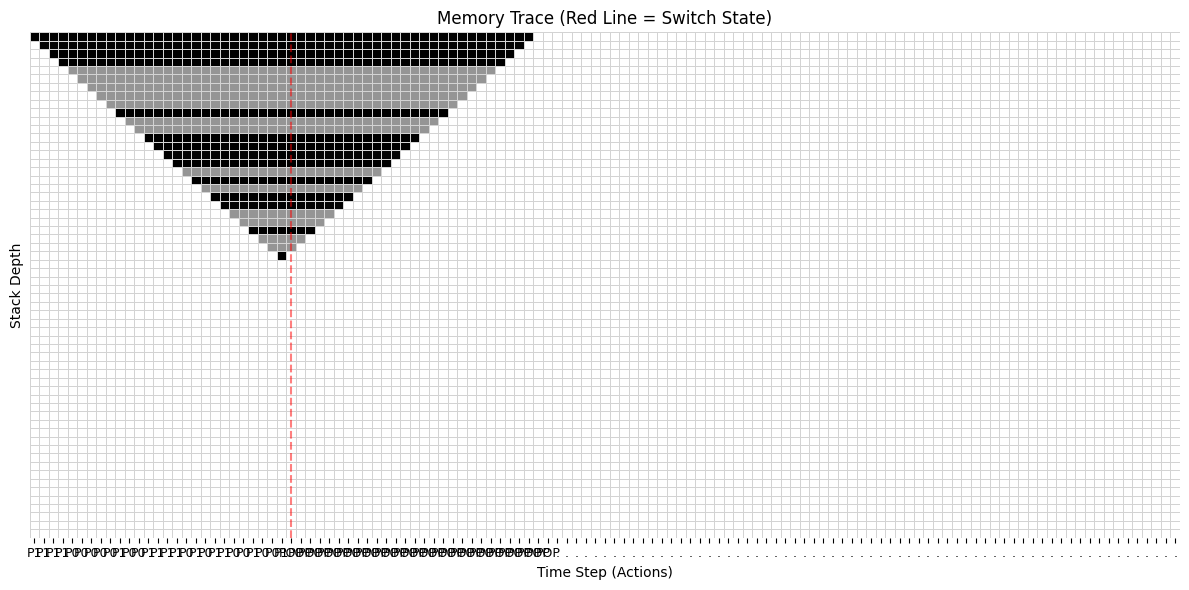

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import numpy as np

def visualize_trace(apply_fn, params, seq_len):
    print(f"--- Visualizing Trace for Length {seq_len} ---")
    
    # 1. Generate one test sample
    key = jax.random.PRNGKey(42)
    batch = generate_rev_trace( 1, seq_len)
    inputs, tgt_mem, tgt_buf, tgt_state = batch
    
    # 2. Run Inference
    # FIX: Call apply_fn directly. Do not use .apply()
    # We pass use_forcing=False (last argument)
    logits = apply_fn(params, inputs, tgt_mem, tgt_state, False)
    
    pred_mem = jnp.argmax(logits[0], -1)[0] # [Seq]
    pred_buf = jnp.argmax(logits[1], -1)[0]
    
    # 3. Reconstruct Stack History
    # Since the model scan doesn't return the stack states, we simulate it 
    # using the *predicted* actions to see what the controller thinks it's doing.
    stack_history = []
    stack = np.zeros(STACK_DEPTH, dtype=int) # Depth 20
    ptr = 0
    
    # Move to numpy for simulation loop
    pred_mem_np = np.array(pred_mem)
    
    for t in range(seq_len*2+1):
        act = pred_mem_np[t]
        
        # Logic matches update_stack:
        # 1 (PUSH 0), 2 (PUSH 1), 3 (POP)
        if act == 1: # Push 0
            stack[ptr] = 1 # We store '1' for bit 0 to distinguish from empty
            ptr += 1
        elif act == 2: # Push 1
            stack[ptr] = 2 # We store '2' for bit 1
            ptr += 1
        elif act == 3: # Pop
            if ptr > 0:
                ptr -= 1
                stack[ptr] = 0
        
        # Store copy of current stack state
        stack_history.append(stack.copy())
        
    stack_history = np.array(stack_history).T # Shape: [Depth, Time]

    # 4. Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Color map: White=Empty, Light Grey=0, Dark Grey=1
    # We map our stack values (0, 1, 2) to colors
    sns.heatmap(stack_history, cmap="Greys", cbar=False, 
                linewidths=0.5, linecolor='lightgray', ax=ax, vmin=0, vmax=2)
    
    # Annotate x-axis with Actions
    # Map raw integers to labels
    actions_map = {0: '.', 1: 'P0', 2: 'P1', 3: 'POP'}
    act_labels = [actions_map[a] for a in pred_mem_np]
    
    ax.set_xticks(np.arange(seq_len*2 + 1) + 0.5)
    ax.set_xticklabels(act_labels, rotation=0, fontsize=9)
    ax.set_xlabel("Time Step (Actions)")
    
    
    # Map predictions: 0->., 1->0, 2->1
    buf_labels = []
    for b in np.array(pred_buf):
        if b == 0: buf_labels.append('.')
        elif b == 1: buf_labels.append('0')
        elif b == 2: buf_labels.append('1')
        

    # Draw a vertical line where the '=' sign was (approximate by looking at inputs)
    # The input sequence is in inputs[0]
    eq_indices = np.where(inputs[0] == 3)[0] # 3 is '='
    if len(eq_indices) > 0:
        plt.axvline(x=eq_indices[0] + 0.5, color='red', linestyle='--', alpha=0.5)
    
    plt.title(f"Memory Trace (Red Line = Switch State)")
    plt.ylabel("Stack Depth")
    plt.yticks([]) # Hide depth numbers for cleanliness
    plt.tight_layout()
    plt.show()

# Usage:
# Pass state.apply_fn (the function) and state.params (the weights)
visualize_trace(state.apply_fn, state.params, SEQ_LENGTH)

In [11]:
def test_generalization(state, test_len):
    print(f"\n--- Testing Generalization on Length {test_len} ---")
    # Generate batch with new length
    
    key = jax.random.PRNGKey(101)
    batch = generate_rev_trace(1000, test_len) # Batch 100
    inputs, tgt_mem, tgt_buf, tgt_state = batch
    
    # inference
    logits = state.apply_fn(state.params, inputs, tgt_mem, tgt_state, False)
    pred_buf = jnp.argmax(logits[1], -1)
    
    # Accuracy
    correct = (pred_buf == tgt_buf)
    #print an incorrect example?
    for i in range(1000) :
      if not jnp.array_equal(tgt_buf[i], pred_buf[i]):
        print(tgt_buf[i], pred_buf[i])
        break
    acc = correct.mean()
    
    print(f"Accuracy on Length {test_len}: {acc:.2%}")

test_generalization(state, SEQ_LENGTH * 2)


--- Testing Generalization on Length 120 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 1
 1 2 2 2 1 2 2 2 2 1 1 2 1 2 2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 1
 2 1 2 1 1 2 1 2 2 1 2 1 1 1 1 1 1 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 2 2 1 2 1
 2 1 1 2 1 1 1 2 1 2 1 1 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 1 2 1 1 1 1 1 1 2 1 1 2 2 2 1 1 2 1 1 1 1 1 1 2 2 1 2 1
 2 1 1 2 1 1 1 2 1 2 1 1 2 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

Searching for a failure case at length 120...
Found failure on attempt 0! (Relevant Length: 120)


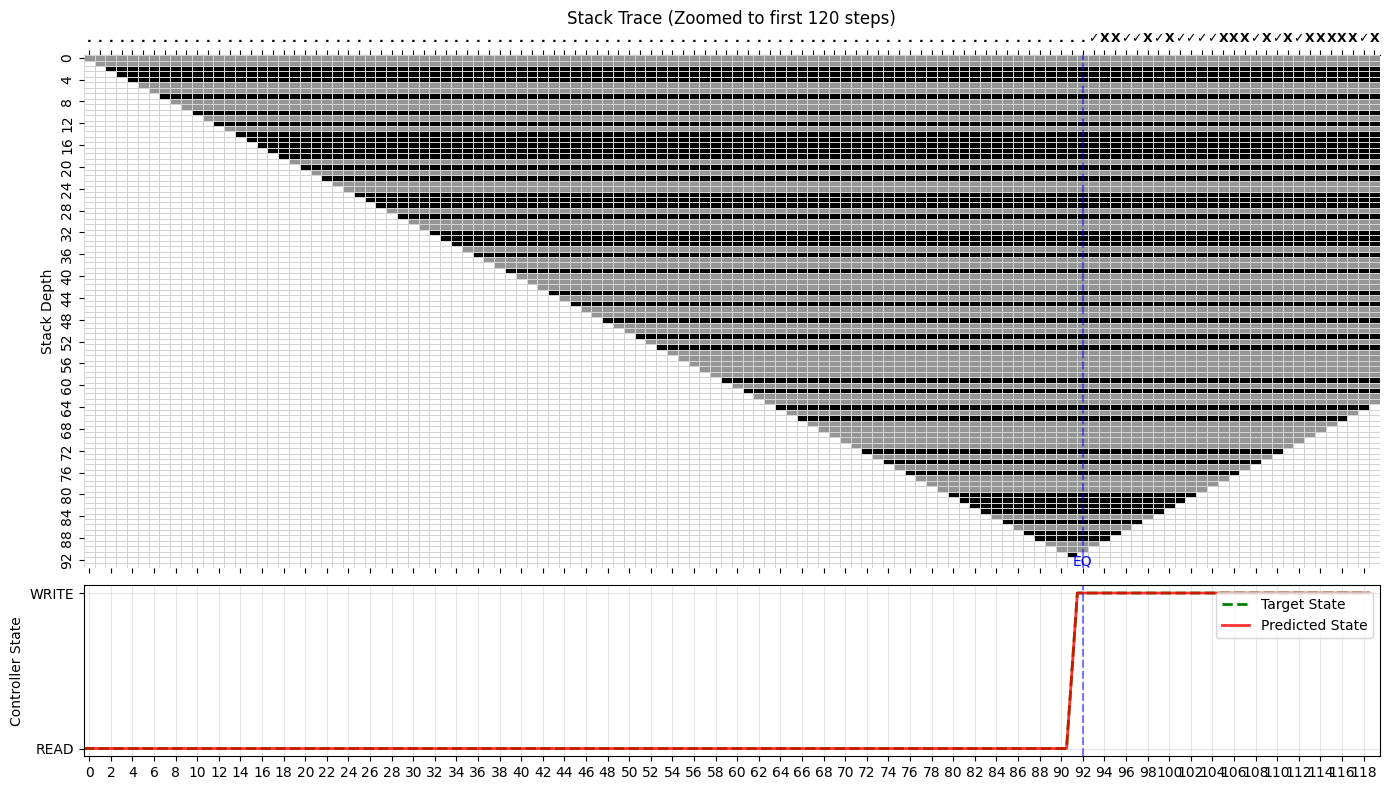

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp

def visualize_failure_zoomed(apply_fn, params, seq_len):
    print(f"Searching for a failure case at length {seq_len}...")
    
    max_tries = 1000
    found_fail = False
    
    for i in range(max_tries):
        # 1. Generate Batch (No Key Argument)
        # Assuming generate_rev_trace returns (inputs, tgt_mem, tgt_buf, tgt_state, mask)
        # If your function doesn't return a mask, we can ignore the 5th return value
        batch_out = generate_rev_trace(1, seq_len)
        inputs, tgt_mem, tgt_buf, tgt_state = batch_out[:4]
        
        # 2. Run Inference
        logits = apply_fn(params, inputs, tgt_mem, tgt_state, False)
        pred_buf = jnp.argmax(logits[1], -1)[0]
        tgt_buf_sq = tgt_buf[0]
        
        # 3. Detect "Active" Region for Zooming
        # Find the last index where the target buffer or input is not 0 (PAD)
        # We look for the last 'event' to crop the plot
        last_input_idx = np.max(np.where(inputs[0] != 0)[0])
        last_tgt_idx = np.max(np.where(tgt_buf_sq != 0)[0]) if np.any(tgt_buf_sq != 0) else 0
        
        # The relevant end is the later of the two, plus a small margin (e.g. 2 steps)
        relevant_len = max(last_input_idx, last_tgt_idx) + 3
        relevant_len = min(relevant_len, seq_len) # Clamp to max length
        
        # 4. Check for Failure (only in the relevant region)
        # We compare only up to relevant_len
        is_correct = jnp.array_equal(pred_buf[:relevant_len], tgt_buf_sq[:relevant_len])
        
        if not is_correct:
            print(f"Found failure on attempt {i}! (Relevant Length: {relevant_len})")
            found_fail = True
            
            # --- PREPARE DATA ---
            pred_mem = jnp.argmax(logits[0], -1)[0]
            pred_state = jnp.argmax(logits[2], -1)[0]
            
            # Slice to relevant region
            inputs_view = inputs[0, :relevant_len]
            pred_mem_view = pred_mem[:relevant_len]
            pred_buf_view = pred_buf[:relevant_len]
            tgt_buf_view = tgt_buf_sq[:relevant_len]
            tgt_state_view = tgt_state[0, :relevant_len]
            pred_state_view = pred_state[:relevant_len]
            
            # --- SIMULATE STACK FOR HEATMAP ---
            stack_history = []
            stack = np.zeros(100, dtype=int) # Large buffer
            ptr = 0
            max_ptr_reached = 0
            
            pred_mem_np = np.array(pred_mem_view)
            for t in range(relevant_len):
                act = pred_mem_np[t]
                if act == 1: stack[ptr] = 1; ptr += 1 # Push 0
                elif act == 2: stack[ptr] = 2; ptr += 1 # Push 1
                elif act == 3: # Pop
                    if ptr > 0: ptr -= 1; stack[ptr] = 0
                
                max_ptr_reached = max(max_ptr_reached, ptr)
                stack_history.append(stack.copy())
            
            # Transpose for plotting: [Depth, Time]
            stack_history = np.array(stack_history).T
            
            # Crop Stack Depth (Y-Axis Zoom)
            # Show up to max depth used + 2 empty rows
            display_depth = max(5, max_ptr_reached + 2) 
            stack_history = stack_history[:display_depth, :]

            # --- PLOTTING ---
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), 
                                           sharex=True, gridspec_kw={'height_ratios': [3, 1]})
            
            # Plot 1: Stack Heatmap
            sns.heatmap(stack_history, cmap="Greys", cbar=False, 
                        linewidths=0.5, linecolor='lightgray', ax=ax1, vmin=0, vmax=2)
            
            ax1.set_title(f"Stack Trace (Zoomed to first {relevant_len} steps)")
            ax1.set_ylabel("Stack Depth")
            
            # Annotate Top with Buffer Outputs (Pred vs Target)
            sec_ax = ax1.secondary_xaxis('top')
            sec_ax.set_xticks(np.arange(relevant_len) + 0.5)
            
            buf_labels = []
            for t in range(relevant_len):
                p = pred_buf_view[t]
                g = tgt_buf_view[t]
                
                if p == g and p == 0: lbl = "."     # Correct Silence
                elif p == g: lbl = "✓"              # Correct Emit
                elif g == 0: lbl = f"E({p-1})"      # Hallucination (Expected Silence)
                else: lbl = "X"                     # Wrong Bit
                buf_labels.append(lbl)
            
            sec_ax.set_xticklabels(buf_labels, fontsize=9, fontweight='bold')
            
            # Plot 2: State Stability
            ax2.plot(tgt_state_view, label="Target State", color='green', linestyle='--', linewidth=2)
            ax2.plot(pred_state_view, label="Predicted State", color='red', alpha=0.8, linewidth=2)
            ax2.set_yticks([0, 1])
            ax2.set_yticklabels(["READ", "WRITE"])
            ax2.set_ylabel("Controller State")
            ax2.legend(loc='upper right')
            ax2.grid(True, alpha=0.3)
            
            # Mark the Equal Sign
            eq_indices = np.where(inputs_view == 3)[0]
            if len(eq_indices) > 0:
                eq_x = eq_indices[0] + 0.5
                ax1.axvline(x=eq_x, color='blue', linestyle='--', alpha=0.5)
                ax2.axvline(x=eq_x, color='blue', linestyle='--', alpha=0.5)
                ax1.text(eq_x, display_depth - 0.5, "EQ", color='blue', ha='center')

            plt.tight_layout()
            plt.show()
            break

    if not found_fail:
        print("No failures found in 1000 attempts.")

# Usage
visualize_failure_zoomed(state.apply_fn, state.params, 120)

---
# Train w/ no teacher forcing?

In [13]:
key = jax.random.PRNGKey(42)

# Initialize
model = NeuralStackMachine()


# Init with forcing=False
dummy_x = jnp.zeros((BATCH_SIZE, SEQ_LENGTH), dtype=jnp.int32)
params = model.init(key, dummy_x, dummy_x, dummy_x, use_forcing=False)

tx = optax.adam(LEARNING_RATE)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Loss Function
def loss_fn(params, batch):
    inputs, tgt_mem, tgt_buf, tgt_state = batch
    logits = model.apply(params, inputs, tgt_mem, tgt_state, use_forcing=False)
    l_mem, l_buf, l_state = logits
    
    loss_m = optax.softmax_cross_entropy_with_integer_labels(l_mem, tgt_mem).mean()
    loss_b = optax.softmax_cross_entropy_with_integer_labels(l_buf, tgt_buf).mean()
    loss_s = optax.softmax_cross_entropy_with_integer_labels(l_state, tgt_state).mean()

    acc = (jnp.argmax(l_buf, -1) == tgt_buf).mean()
    
    return loss_m + loss_b + loss_s, acc

train_step = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))

print("Training...")
for step in range(STEPS):
    key, subkey = jax.random.split(key)
    batch = generate_rev_trace( BATCH_SIZE)
    
    (loss, acc), grads = train_step(state.params, batch)
    state = state.apply_gradients(grads=grads)
    
    if step % 200 == 0:
        print(f"Step {step} | Loss: {loss:.4f} | Buffer Acc: {acc:.2%}")
        

#INFERENCE
print("\nInference (No Teacher Forcing)...")
test_batch = generate_rev_trace(1)
inp, tgt_m, tgt_b, tgt_s = test_batch

# Inference Mode: use_forcing = False
logits = model.apply(state.params, inp, tgt_m, tgt_s, use_forcing=False) 
pred_buf = jnp.argmax(logits[1], -1)

print(f"Target: {tgt_b[0]}")
print(f"Pred:   {pred_buf[0]}")
print(f"Match:  {jnp.array_equal(tgt_b[0], pred_buf[0])}")

Training...
Step 0 | Loss: 3.4479 | Buffer Acc: 14.05%
Step 200 | Loss: 1.7102 | Buffer Acc: 74.20%
Step 400 | Loss: 0.8364 | Buffer Acc: 87.40%
Step 600 | Loss: 0.4468 | Buffer Acc: 100.00%
Step 800 | Loss: 0.3042 | Buffer Acc: 100.00%
Step 1000 | Loss: 0.2303 | Buffer Acc: 100.00%
Step 1200 | Loss: 0.1854 | Buffer Acc: 100.00%
Step 1400 | Loss: 0.1606 | Buffer Acc: 100.00%
Step 1600 | Loss: 0.1422 | Buffer Acc: 100.00%
Step 1800 | Loss: 0.1286 | Buffer Acc: 100.00%

Inference (No Teacher Forcing)...
Target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 2 1 2 2 1 1 1 1 1 2 1 2 1 2 1 1 1 1 2 1
 2 2 1 2 2 1 1 2 2 1 1 2 2 1 1 1 1 2 2 2 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Pred:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 2 1 2 2 1 1 1 1 1 2 1 2 1 2 1 1 1 1 2 1
 2 2 1 2 2 1 1 2 2 1 1 2 2 1 1 1 1 2 2 2 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 

In [14]:
test_generalization(state, SEQ_LENGTH * 2)


--- Testing Generalization on Length 120 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 2 2 1 2 2 2 2 2 1 2 1 1 2 1 1 2 1 2 1 2 1 1 1 1 2
 2 2 1 1 2 2 1 2 2 2 2 2 1 2 2 1 2 2 1 1 1 2 2 1 2 2 1 2 2 2 2 1 1 1 1 2 1
 1 2 1 2 2 1 2 1 2 2 2 1 2 1 1 2 2 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 2 1 1 2 2 1 2 2 2 2 2 1 2 2 1 2 2 1 1 1 2 2 1 2 2 1 2 2 2 2 1 1 1 1 2 1
 1 2 1 2 2 1 2 1 2 2 2 1 2 1 1 2 2 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

---
# One hot for input embedding

In [15]:
HIDDEN_DIM = 4
# Initialize
model = NeuralStackMachine()


# Init with forcing=True
dummy_x = jnp.zeros((BATCH_SIZE, SEQ_LENGTH), dtype=jnp.int32)
params = model.init(key, dummy_x, dummy_x, dummy_x, use_forcing=True)

tx = optax.adam(LEARNING_RATE)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Loss Function
def loss_fn(params, batch):
    inputs, tgt_mem, tgt_buf, tgt_state = batch
    logits = model.apply(params, inputs, tgt_mem, tgt_state, use_forcing=True)
    l_mem, l_buf, l_state = logits
    
    loss_m = optax.softmax_cross_entropy_with_integer_labels(l_mem, tgt_mem).mean()
    loss_b = optax.softmax_cross_entropy_with_integer_labels(l_buf, tgt_buf).mean()
    loss_s = optax.softmax_cross_entropy_with_integer_labels(l_state, tgt_state).mean()

    acc = (jnp.argmax(l_buf, -1) == tgt_buf).mean()
    
    return loss_m + loss_b + loss_s, acc

train_step = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))

print("Training...")
for step in range(STEPS):
    key, subkey = jax.random.split(key)
    batch = generate_rev_trace( BATCH_SIZE)
    
    (loss, acc), grads = train_step(state.params, batch)
    state = state.apply_gradients(grads=grads)
    
    if step % 200 == 0:
        print(f"Step {step} | Loss: {loss:.4f} | Buffer Acc: {acc:.2%}")
        

#INFERENCE
print("\nInference (No Teacher Forcing)...")
test_batch = generate_rev_trace(1)
inp, tgt_m, tgt_b, tgt_s = test_batch

# Inference Mode: use_forcing = False
logits = model.apply(state.params, inp, tgt_m, tgt_s, use_forcing=False) 
pred_buf = jnp.argmax(logits[1], -1)

print(f"Target: {tgt_b[0]}")
print(f"Pred:   {pred_buf[0]}")
print(f"Match:  {jnp.array_equal(tgt_b[0], pred_buf[0])}")

Training...
Step 0 | Loss: 3.3235 | Buffer Acc: 11.88%
Step 200 | Loss: 1.7367 | Buffer Acc: 100.00%
Step 400 | Loss: 1.0517 | Buffer Acc: 100.00%
Step 600 | Loss: 0.6109 | Buffer Acc: 100.00%
Step 800 | Loss: 0.4085 | Buffer Acc: 100.00%
Step 1000 | Loss: 0.3007 | Buffer Acc: 100.00%
Step 1200 | Loss: 0.2414 | Buffer Acc: 100.00%
Step 1400 | Loss: 0.1977 | Buffer Acc: 100.00%
Step 1600 | Loss: 0.1687 | Buffer Acc: 100.00%
Step 1800 | Loss: 0.1478 | Buffer Acc: 100.00%

Inference (No Teacher Forcing)...
Target: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 2 1 2 2 2 1 1 2 2 1 2 2 2 1 1 1 2 2 2 2 2 1 2 2 2 1 2 2 2
 2 1 2 2 1 2 1 2 1 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Pred:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 2 1 2 2 2 1 1 2 2 1 2 2 2 1 1 1 2 2 2 2 2 1 2 2 2 1 2 2 2
 2 1 2 2 1 2 1 2 1 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 

In [16]:
test_generalization(state, SEQ_LENGTH * 2)


--- Testing Generalization on Length 120 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 2 2 2 1 1 1 1 1 1 2 2 1 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1
 2 2 1 2 1 1 2 1 2 1 2 2 2 2 1 2 1 2 2 2 1 2 2 1 2 1 2 2 2 1 2 1 1 2 1 1 1
 1 2 1 2 2 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1
 2 2 1 2 1 1 2 1 2 1 2 2 2 2 1 2 1 2 2 2 1 2 2 1 2 1 2 2 2 1 2 1 1 2 1 1 1
 1 2 1 2 2 1 1 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

- compare with softer stacks
- more stacks?
- benchmark against chomsky models

----


In [17]:
key = jax.random.PRNGKey(42)

# Initialize
model = NeuralSoftStackMachine()


# Init with forcing=True
dummy_x = jnp.zeros((BATCH_SIZE, SEQ_LENGTH), dtype=jnp.int32)
params = model.init(key, dummy_x, dummy_x, dummy_x, use_forcing=True)

tx = optax.adam(LEARNING_RATE)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Loss Function
def loss_fn(params, batch):
    inputs, tgt_mem, tgt_buf, tgt_state = batch
    logits = model.apply(params, inputs, tgt_mem, tgt_state, use_forcing=True)
    l_mem, l_buf, l_state = logits
    
    loss_m = optax.softmax_cross_entropy_with_integer_labels(l_mem, tgt_mem).mean()
    loss_b = optax.softmax_cross_entropy_with_integer_labels(l_buf, tgt_buf).mean()
    loss_s = optax.softmax_cross_entropy_with_integer_labels(l_state, tgt_state).mean()

    acc = (jnp.argmax(l_buf, -1) == tgt_buf).mean()
    
    return loss_m + loss_b + loss_s, acc

train_step = jax.jit(jax.value_and_grad(loss_fn, has_aux=True))

print("Training...")
for step in range(STEPS):
    key, subkey = jax.random.split(key)
    batch = generate_rev_trace( BATCH_SIZE)
    
    (loss, acc), grads = train_step(state.params, batch)
    state = state.apply_gradients(grads=grads)
    
    if step % 200 == 0:
        print(f"Step {step} | Loss: {loss:.4f} | Buffer Acc: {acc:.2%}")
        

#INFERENCE
print("\nInference (No Teacher Forcing)...")
test_batch = generate_rev_trace(1)
inp, tgt_m, tgt_b, tgt_s = test_batch

# Inference Mode: use_forcing = False
logits = model.apply(state.params, inp, tgt_m, tgt_s, use_forcing=False) 
pred_buf = jnp.argmax(logits[1], -1)

print(f"Target: {tgt_b[0]}")
print(f"Pred:   {pred_buf[0]}")
print(f"Match:  {jnp.array_equal(tgt_b[0], pred_buf[0])}")

Training...
Step 0 | Loss: nan | Buffer Acc: 61.94%
Step 200 | Loss: nan | Buffer Acc: 73.73%
Step 400 | Loss: nan | Buffer Acc: 77.52%
Step 600 | Loss: nan | Buffer Acc: 76.24%
Step 800 | Loss: nan | Buffer Acc: 76.52%
Step 1000 | Loss: nan | Buffer Acc: 73.63%
Step 1200 | Loss: nan | Buffer Acc: 76.67%
Step 1400 | Loss: nan | Buffer Acc: 75.15%
Step 1600 | Loss: nan | Buffer Acc: 74.46%
Step 1800 | Loss: nan | Buffer Acc: 77.03%

Inference (No Teacher Forcing)...
Target: [0 0 0 0 0 0 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Pred:   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
Match:  False


In [18]:
test_generalization(state, SEQ_LENGTH * 2)


--- Testing Generalization on Length 120 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 1 1 2 1 2 1 1 1 1 1 1 1 2 2 2 1 2 1 1 2 1 1 2 2 2 2 2 1 1 2 1 1 2 2 2
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

---

In [19]:
class VanillaRNN(nn.Module):
    hidden_dim: int = HIDDEN_DIM  
    @nn.compact
    def __call__(self, x, true_act, true_s, use_forcing):
        batch_size, seq_len = x.shape
        
        lstm = nn.LSTMCell(features=HIDDEN_DIM)

        carry = (jnp.zeros((batch_size, HIDDEN_DIM)), 
                 jnp.zeros((batch_size, HIDDEN_DIM)))
        
        def cell(carry, x_t):
            new_carry, new_h = lstm(carry, nn.Embed(VOCAB_SIZE, HIDDEN_DIM)(x_t))
            return new_carry, new_h

        _, hidden = nn.scan(cell, variable_broadcast="params", split_rngs={"params": False}, in_axes=1, out_axes=1)(carry, x)
        
        return nn.Dense(NUM_BUF_ACTIONS)(hidden)

In [20]:

def train_vanilla():
    key = jax.random.PRNGKey(42)
    
    model = VanillaRNN(hidden_dim=HIDDEN_DIM)
    
    dummy_x = jnp.zeros((BATCH_SIZE, SEQ_LENGTH), dtype=jnp.int32)
    params = model.init(key, dummy_x, dummy_x, dummy_x, False)
    
    tx = optax.adam(LEARNING_RATE)
    state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)
    
    # loss on buffer only
    @jax.jit
    def train_step(state, batch):
        inputs, tgt_mem, tgt_buf, tgt_state = batch
        
        def loss_fn(params):
            logits_buf = model.apply(params, inputs, tgt_mem, tgt_state, False)
            
            loss_b = optax.softmax_cross_entropy_with_integer_labels(logits_buf, tgt_buf).mean()
            
            acc = (jnp.argmax(logits_buf, -1) == tgt_buf).mean()
            return loss_b, acc
            
        (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
        state = state.apply_gradients(grads=grads)
        return state, loss, acc

    #Train
    print("Training Vanilla LSTM...")
    for step in range(STEPS):
        
        batch = generate_rev_trace(BATCH_SIZE)
        
        state, loss, acc = train_step(state, batch)
        
        if step % 200 == 0:
            print(f"Step {step} | Loss: {loss:.4f} | Buffer Acc: {acc:.2%}")
            
    return state

vanilla_state = train_vanilla()

AttributeError: 'tuple' object has no attribute '_state'